<a href="https://colab.research.google.com/github/AndreaReid/GGE6505/blob/main/GGE6505_A4_Group8_DataPreprocessing_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import csv file from URL

In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing

In [129]:
# Read data file from url
url_detailed = "https://raw.githubusercontent.com/AndreaReid/GGE6505/main/A4/listings_detailed.csv"
url_summary = "https://raw.githubusercontent.com/AndreaReid/GGE6505/main/A4/listings.csv"
df = pd.read_csv(url_summary)

# Data Exploration and Visualization

In [130]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,10080,D1 - Million Dollar View 2 BR,30899,Rami,NaN,Downtown,49.28872,-123.12046,Entire home/apt,158,90,16,2017-02-26,0.13,39,0,0,18-476608
1,13188,Garden level studio in ideal loc.,51466,Family Guns,NaN,Riley Park,49.24773,-123.10509,Entire home/apt,150,2,254,2021-11-26,1.77,1,164,7,20-160253
2,13358,Monthly (or Longer ) Designer One Bedroom Down...,52116,Lynn,NaN,West End,49.28201,-123.12669,Entire home/apt,85,30,431,2021-11-15,3.09,1,46,2,18-611603
3,13490,Vancouver's best kept secret,52467,Iris,NaN,Kensington-Cedar Cottage,49.25622,-123.06607,Entire home/apt,150,30,91,2021-10-31,0.71,1,246,3,NaN
4,14267,EcoLoft Vancouver,56030,Peter & Alison,NaN,Kensington-Cedar Cottage,49.24922,-123.08139,Entire home/apt,150,3,34,2021-07-14,0.25,1,14,1,21-156500


In [131]:
# check shape and size of data
shape = df.shape

print(shape)


(4531, 18)


# Finding missing data, remove and justify choice

In [132]:
# Finding all the null values
df.isnull().sum()

id                                   0
name                                 0
host_id                              0
host_name                            1
neighbourhood_group               4531
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
last_review                        749
reviews_per_month                  749
calculated_host_listings_count       0
availability_365                     0
number_of_reviews_ltm                0
license                           1347
dtype: int64

In the above list, two attributes have 749 null entries. These attributes appear to be related to number of reviews, so we have a closer look to see if the null values are because of missing reviews.

In [133]:
# Drop Neighbourhood_group and License
# Compare with number_of_reviews to justify potential drop

df_compare = df[['number_of_reviews', 'last_review', 'reviews_per_month']].sort_values(by='number_of_reviews')

df_compare.head(10)

,number_of_reviews,last_review,reviews_per_month
4530,0,NaN,NaN
3887,0,NaN,NaN
2949,0,NaN,NaN
853,0,NaN,NaN
3883,0,NaN,NaN
3878,0,NaN,NaN
3877,0,NaN,NaN
3876,0,NaN,NaN
3875,0,NaN,NaN
3874,0,NaN,NaN


In [134]:
# since number_of_reviews == 0, replace null integer values with 0
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)

# Replace null date values with 'No Reviews'
df['last_review'] = df['last_review'].replace(np.nan, 'No Reviews')

# Drop null column
df = df.drop(axis=1, columns=['neighbourhood_group', 'license'])

# Drop remaining null records
df = df.dropna(axis= 0)


df.isnull().sum()


id                                0
name                              0
host_id                           0
host_name                         0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
last_review                       0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
number_of_reviews_ltm             0
dtype: int64

In [135]:
# Get numeric features only

df_num = df.select_dtypes(np.number)


Text(0.5, 1.0, 'Availability')

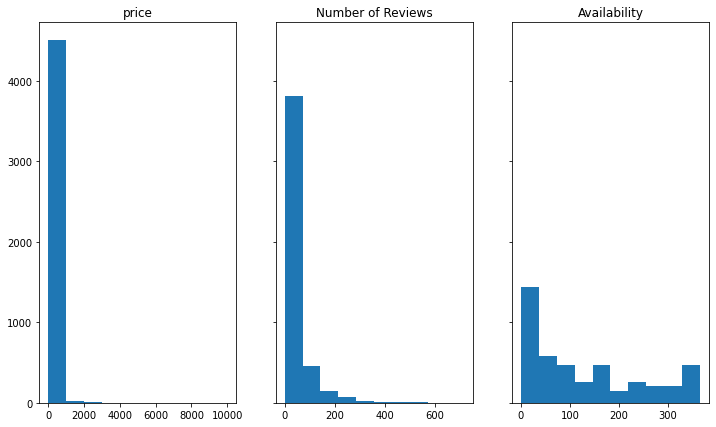

In [136]:
# Plot histograms

fig, ax = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(12,7))
ax = ax.ravel() 

ax[0].hist(df_num['price'])
title = 'price'
ax[0].set_title(title)
ax[1].hist(df_num['number_of_reviews'])
title = 'Number of Reviews'
ax[1].set_title(title)
ax[2].hist(df_num['availability_365'])
title = 'Availability'
ax[2].set_title(title)

The range of prices appears suspicious. Perhaps there are some incorrect values? 

# Remove Noisy Data (binning, clustering, ML algorithms)

In [137]:
print('Describing Price\n')
df.price.describe()

Describing Price



count    4530.000000
mean      178.975497
std       290.722968
min        13.000000
25%        92.250000
50%       129.000000
75%       199.000000
max      9999.000000
Name: price, dtype: float64

The standard deviation is much larger than the mean. And the max price is either an error or a legitimate outlier. The 25% to 75% range appear within the same order of magnitude. 

In [138]:
outliers = df.query('price > 2000')
outliers['id'].count()

10

In [139]:
#Removing remainder of outliers

index = df.index[df['price'] >= 2000]

df.drop(index, inplace=True)

To make it easier to compare noisy data, we can use binning to generalise the data. In this example, we bin by frequency so that each bin has the same number of observations.

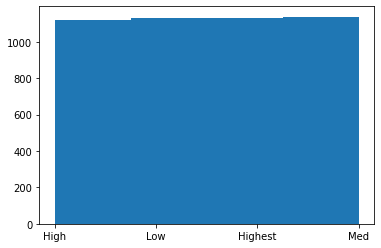

In [140]:
# Binning by frequency

df['bin_qcut'] = pd.qcut(df['price'], q=4, precision=1, labels=['Low', 'Med', 'High', 'Highest'])

plt.hist(df['bin_qcut'], bins=4)
plt.show()

In [141]:
# Group by bin and get mean values of attributes
group = df.groupby('bin_qcut').agg('mean')

# Get numeric attributes only
df_num_bin = group.select_dtypes(np.number)

df_num_bin

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
bin_qcut,,,,,,,,,,,
Low,3.145611e+07,1.220593e+08,49.255880,-123.100179,67.033539,21.692851,40.436893,1.026019,5.296558,109.584289,6.482789
Med,3.209822e+07,1.271776e+08,49.265320,-123.111861,110.015817,19.607206,39.503515,1.205940,6.822496,119.282074,7.841828
High,3.467984e+07,1.343369e+08,49.268877,-123.116191,157.404826,17.022341,36.375335,1.389991,5.746202,130.108132,9.465594
Highest,3.276850e+07,1.229440e+08,49.267626,-123.119873,339.660762,14.203720,28.187777,1.015598,3.177148,148.664305,6.365810


# Standardization

In [142]:
# Standardize a lognormal distribution using maxmin scalar

scaler = preprocessing.MinMaxScaler()
df_num_minmax = scaler.fit_transform(df_num)
print(df_num_minmax)

[[0.00000000e+00 5.71480460e-05 9.38755565e-01 ... 5.00000000e-01
  0.00000000e+00 0.00000000e+00]
 [5.78264661e-05 1.04415957e-04 4.93647519e-01 ... 0.00000000e+00
  4.49315068e-01 2.34113712e-02]
 [6.09894324e-05 1.05909813e-04 8.65892062e-01 ... 0.00000000e+00
  1.26027397e-01 6.68896321e-03]
 ...
 [9.99705491e-01 6.87032771e-02 9.10723531e-01 ... 0.00000000e+00
  7.53424658e-01 0.00000000e+00]
 [9.99707054e-01 3.10091225e-01 5.91003149e-01 ... 0.00000000e+00
  4.57534247e-01 0.00000000e+00]
 [1.00000000e+00 2.90735775e-01 6.59247475e-01 ... 0.00000000e+00
  4.93150685e-01 0.00000000e+00]]


Text(0.5, 1.0, 'Standardized Available 365?')

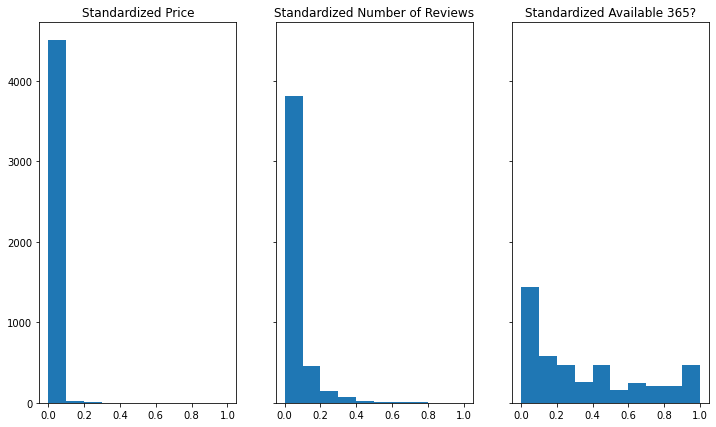

In [143]:
# Plot histograms again

fig, ax = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(12,7))
ax = ax.ravel() 

ax[0].hist(df_num_minmax[:,4])
title = 'Standardized Price'
ax[0].set_title(title)
ax[1].hist(df_num_minmax[:,6])
title = 'Standardized Number of Reviews'
ax[1].set_title(title)
ax[2].hist(df_num_minmax[:,9])
title = 'Standardized Available 365?'
ax[2].set_title(title)


# Normalisation

To be able to compare attributes, we need normalize the data first.

Text(0.5, 1.0, 'X = Standardized Price Y = Standardized Number Reviews')

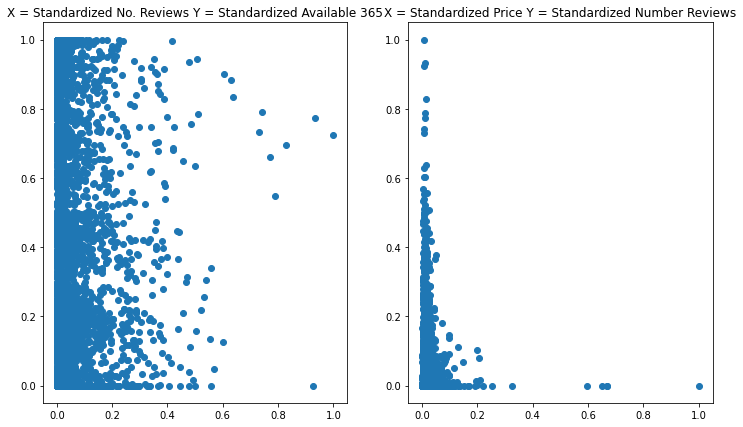

In [144]:
# Plot scatter plots again

fig, ax = plt.subplots(1, 2, sharex='col', figsize=(12,7))
ax = ax.ravel() 

price = df_num_minmax[:,4]
avail = df_num_minmax[:,9]
review = df_num_minmax[:,6]

ax[0].scatter(x=review, y=avail)
title = 'X = Standardized No. Reviews Y = Standardized Available 365'
ax[0].set_title(title)
ax[1].scatter(x=price, y=review)
title = 'X = Standardized Price Y = Standardized Number Reviews'
ax[1].set_title(title)

In [145]:
# normalize the data attributes
normalized = preprocessing.normalize(df_num, "l1")
print("Normalized Data = ", normalized)

Normalized Data =  [[2.43157932e-01 7.45370727e-01 1.18898246e-03 ... 9.40789616e-04
  0.00000000e+00 0.00000000e+00]
 [2.01632499e-01 7.86868229e-01 7.52952902e-04 ... 1.52890885e-05
  2.50741051e-03 1.07023619e-04]
 [2.01646933e-01 7.86721932e-01 7.43941172e-04 ... 1.50955931e-05
  6.94397284e-04 3.01911863e-05]
 ...
 [6.42516976e-01 3.57475547e-01 5.89252588e-07 ... 1.19557467e-08
  3.28783034e-06 0.00000000e+00]
 [2.84837530e-01 7.15158112e-01 2.61068157e-07 ... 5.30015573e-09
  8.85126007e-07 0.00000000e+00]
 [2.98207718e-01 7.01789407e-01 2.73277427e-07 ... 5.54731821e-09
  9.98517278e-07 0.00000000e+00]]


Text(0.5, 1.0, 'X = Normalized Price Y = Normalized No. Reviews')

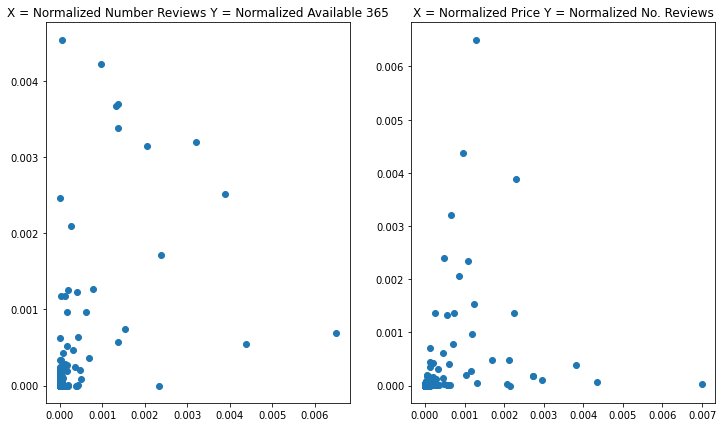

In [146]:
# Plot scatter plots

fig, ax = plt.subplots(1, 2, sharex='col', figsize=(12,7))
ax = ax.ravel() 

price = normalized[:,4]
avail = normalized[:,9]
review = normalized[:,6]

ax[0].scatter(x=review, y=avail)
title = 'X = Normalized Number Reviews Y = Normalized Available 365'
ax[0].set_title(title)
ax[1].scatter(x=price, y=review)
title = 'X = Normalized Price Y = Normalized No. Reviews'
ax[1].set_title(title)

# Visualizing the Cleaned Data

In [147]:
#Describe The columns after 

print('Describing Price\n')
df.price.describe()

Describing Price



count    4519.000000
mean      168.346979
std       147.295259
min        13.000000
25%        92.000000
50%       129.000000
75%       198.000000
max      1993.000000
Name: price, dtype: float64

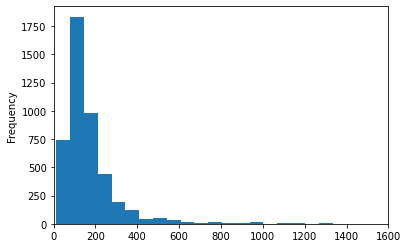

In [148]:
# Price histogram after dropping outliers

df['price'].plot.hist(bins=30, xlim=(0, 1600))

In [149]:
import plotly.express as px
#import geopandas as gpd

#px.set_mapbox_access_token(open("pk.eyJ1IjoidGhvdWdodC1jb3VyaWVyIiwiYSI6ImNsMDhjeGtkYzAyN2ozcmxqNGJwaWw3N3oifQ.G0RRcAKdEo7nQ4TlEBeG1g").read())

#fig = px.scatter_geo(df,lat='latitude',lon='longitude', color='number_of_reviews', hover_name="license", scope='north america', center={'lat':49, 'lon':-123}, basemap_visible=True)
#fig.update_layout(title = 'Air BnB, Vancouver (BC)', title_x=0.5)
#fig.show()

fig = px.scatter_mapbox(df, lat='latitude',lon='longitude', color='price', hover_name="id", zoom=9.9, center={'lat':49.25, 'lon':-123.15}, mapbox_style='open-street-map')
fig.update_layout(title = 'Air BnB, Vancouver (BC)', title_x=0.5)
fig.show()